# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 26.09.2021

Мягкий дедлайн: 23:59MSK 11.10.2021

Жесткий дедлайн: 23:59MSK 14.10.2021

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [3]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train = pd.read_csv("train.zip", compression="zip")

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [4]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train.sample(10)

del train["dropoff_datetime"]

train["pickup_datetime"] = pd.to_datetime(train["pickup_datetime"])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

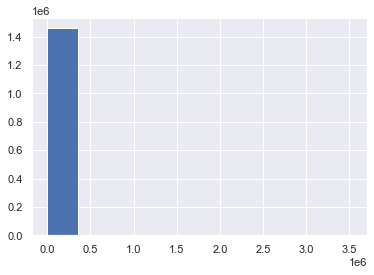

In [5]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.hist(train.trip_duration, bins = 10);


**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [6]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

train["log_trip_duration"] = np.log1p(train.trip_duration)

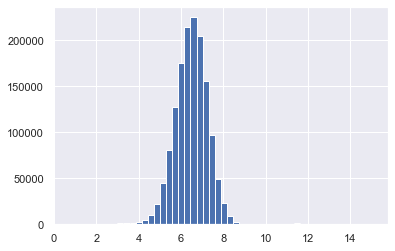

In [7]:
plt.hist(train.log_trip_duration, bins = 50);

In [8]:
del train["trip_duration"]

In [9]:
from sklearn.metrics import mean_squared_error

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [10]:
y_train = train.log_trip_duration

In [11]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
best_constant = y_train.mean()

In [12]:
print("Test RMSE = %.4f" % mean_squared_error(y_train, best_constant * np.ones(y_train.shape), squared=False))

Test RMSE = 0.7958


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [13]:
from datetime import datetime

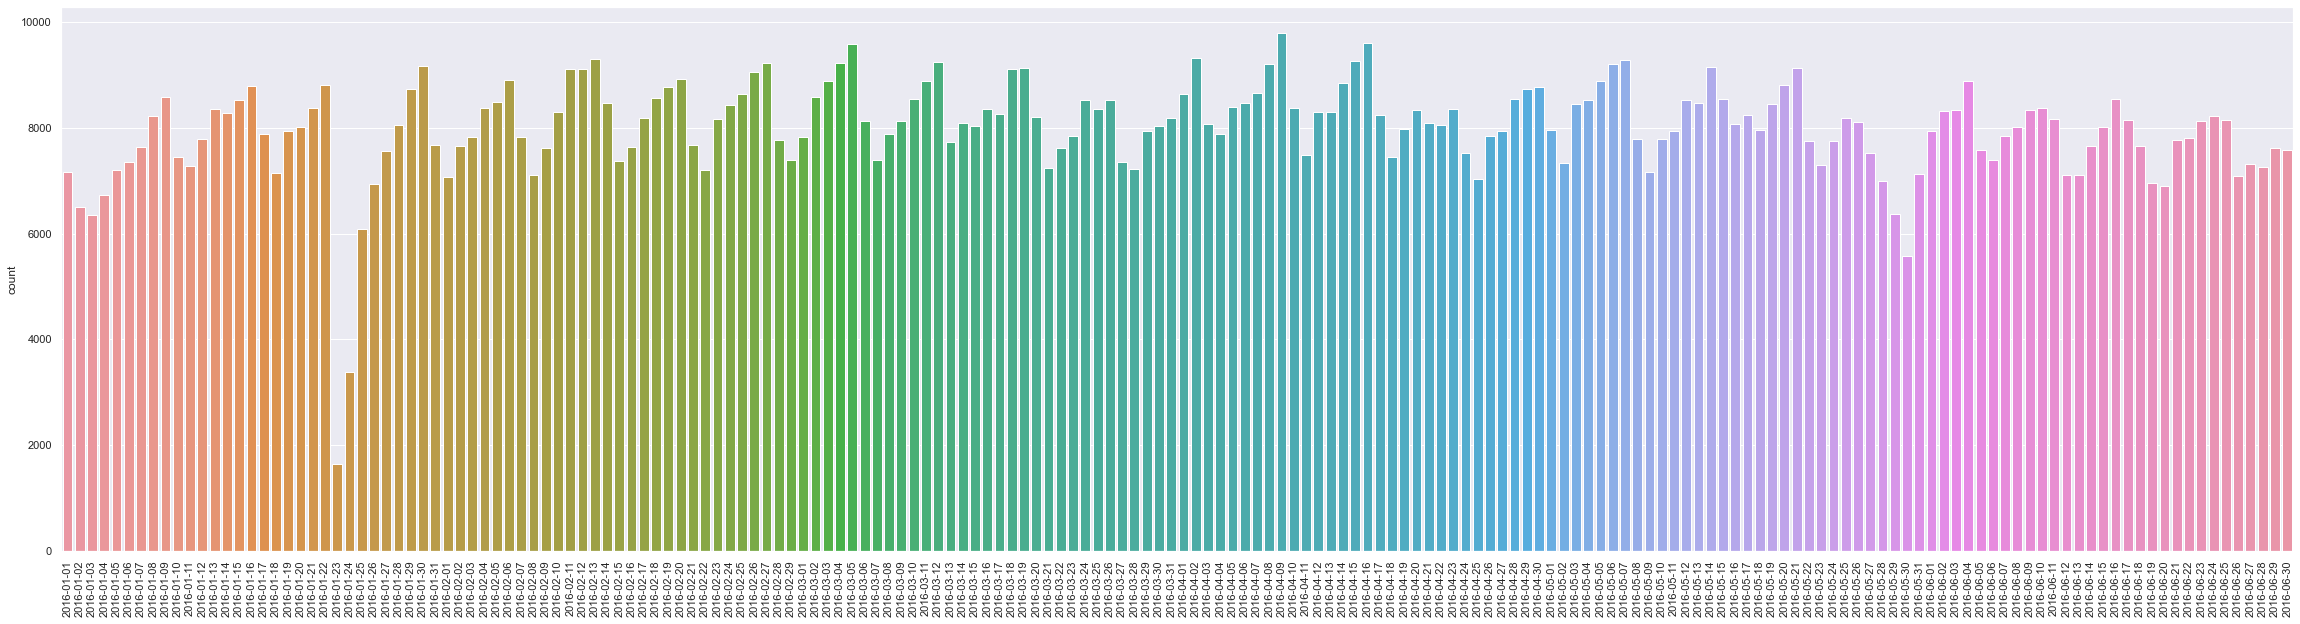

In [14]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.rcParams['figure.figsize'] = (40, 10)
plt.xticks(rotation=90)
sns.countplot(sorted(train['pickup_datetime'].astype(str).str[:10]), orient = "v");

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [15]:
train["dayofweek"] = train.pickup_datetime.dt.dayofweek+1

In [16]:
train["hour"] = train.pickup_datetime.dt.hour

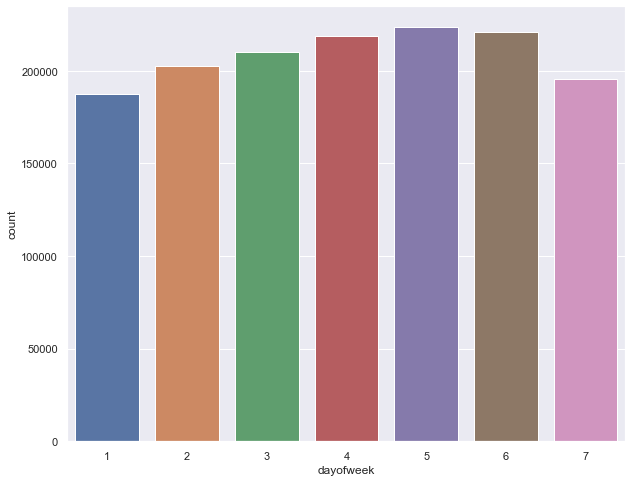

In [17]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.countplot(train["dayofweek"])

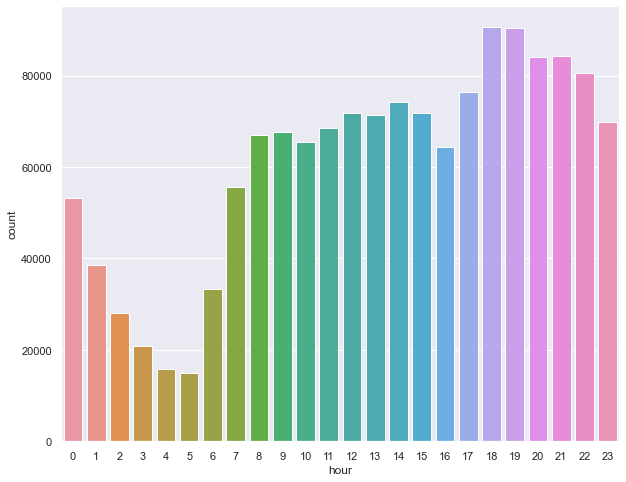

In [18]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.countplot(train["hour"])

In [19]:
train["month"] = train.pickup_datetime.dt.month

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [20]:
month_hour = train.groupby(["month", "hour"]).agg(count_trip = ('id', 'count')).reset_index()
month_dayofweek = train.groupby(["month", "dayofweek"]).agg(count_trip = ('id', 'count')).reset_index()

In [21]:
train["dayofyear"] = train.pickup_datetime.dt.dayofyear

In [22]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train["abnormal_day"] = 0
train.loc[train["pickup_datetime"].astype(str).str[:10].isin(["2016-01-23", "2016-01-24"]), "abnormal_day"] = 1

In [23]:
month_hour.month.unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

In [24]:
month_hour["month"] = month_hour["month"].astype(str)

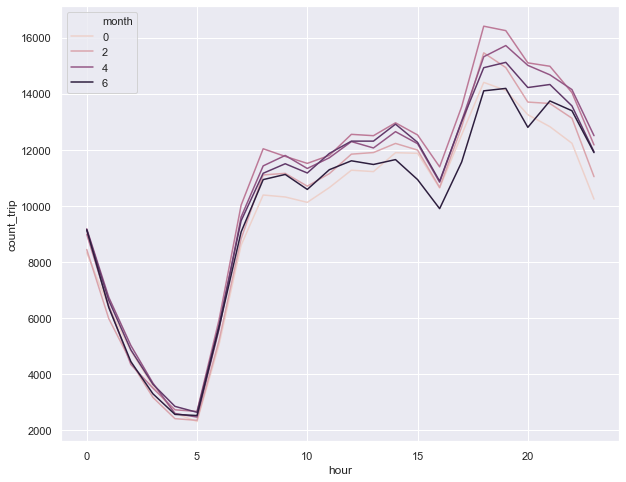

In [25]:
sns.lineplot(x = "hour", y = "count_trip", hue = "month", data = month_hour)

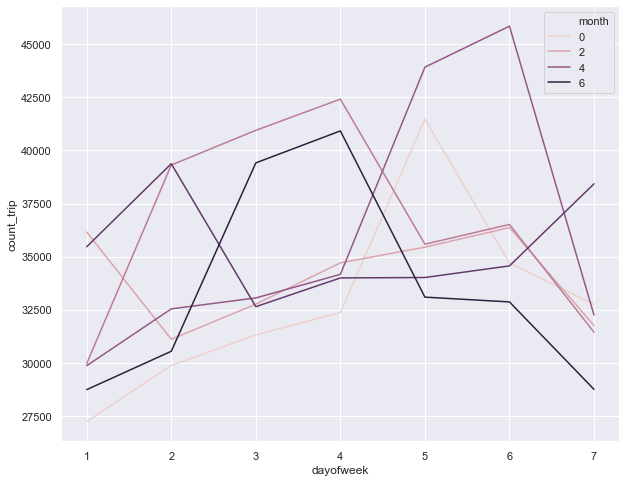

In [26]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
sns.lineplot(x = "dayofweek", y = "count_trip", hue = "month", data = month_dayofweek)


**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [27]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import train_test_split
y = train["log_trip_duration"]
X = train.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

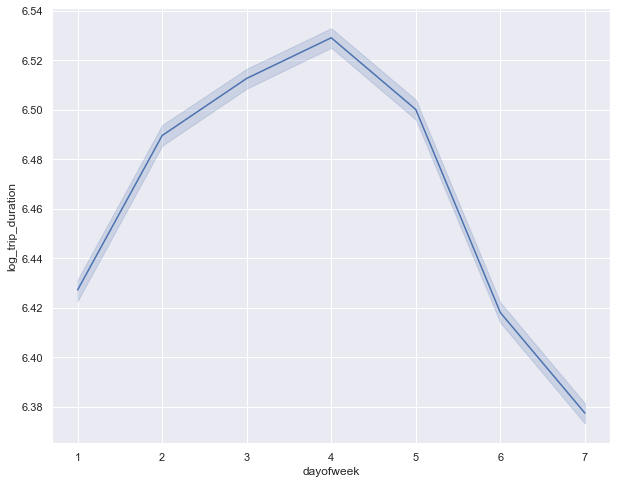

In [28]:
sns.lineplot(x = X_train.dayofweek, y = y, estimator='mean')

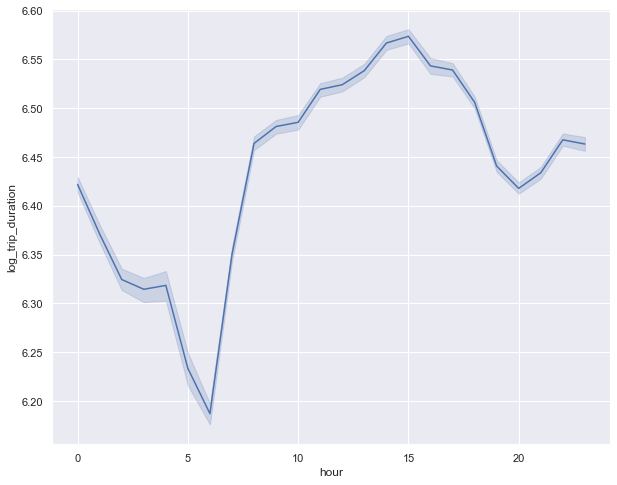

In [29]:
sns.lineplot(x = X_train.hour, y = y, estimator='mean')

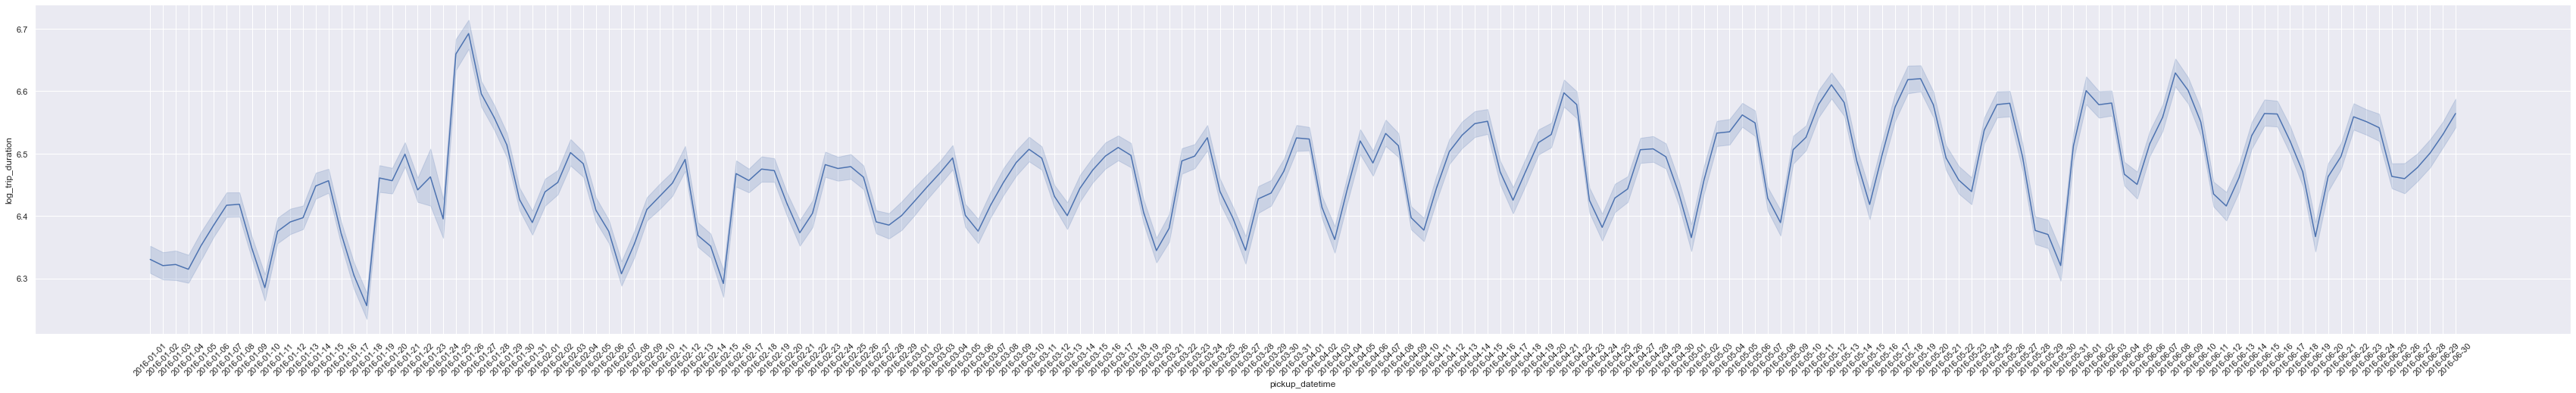

In [30]:
plt.rcParams['figure.figsize'] = (60, 8)
plt.xticks(rotation=45)
sns.lineplot(x = X_train["pickup_datetime"].astype(str).str[:10], y = y, estimator='mean')

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [31]:
numeric_features = ["dayofweek", "month", "hour", "dayofyear"]
categorical = ["abnormal_day"]

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.7925


In [32]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [33]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [34]:
train.sample()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,dayofweek,hour,month,dayofyear,abnormal_day
470753,id1925016,1,2016-04-14 21:31:03,5,-73.976608,40.785835,-74.001465,40.752251,N,6.950815,4,21,4,105,0


In [35]:
show_circles_on_map(train.sort_values(["pickup_longitude"]).head(1), "pickup_latitude", "pickup_longitude", "blue")

In [36]:
show_circles_on_map(train.sort_values(["dropoff_longitude"]).head(1), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [37]:
!pip install haversine

In [38]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from haversine import haversine

In [39]:
train.sample()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,dayofweek,hour,month,dayofyear,abnormal_day
292135,id1542386,1,2016-06-02 10:50:03,1,-73.981201,40.769047,-73.971565,40.755085,N,7.085064,4,10,6,154,0


In [40]:
train["pickup_longitude"][0]

-73.98215484619139

In [41]:
a = (train["pickup_longitude"][0], train["pickup_latitude"][0])
b = (train["dropoff_longitude"][0], train["dropoff_latitude"][0])

In [42]:
train["s"] = train.apply(lambda x: haversine((x["pickup_longitude"], x["pickup_latitude"]), (x["dropoff_longitude"], x["dropoff_latitude"])), axis=1)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [43]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train["log_s"] = np.log1p(train["s"])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [44]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
correlations = train[["s", "log_s"]].corrwith(train["log_trip_duration"]).sort_values(ascending=False)
correlations

log_s    0.675784
s        0.520549
dtype: float64

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [45]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train["log_v"] = train["log_s"] / train["log_trip_duration"]

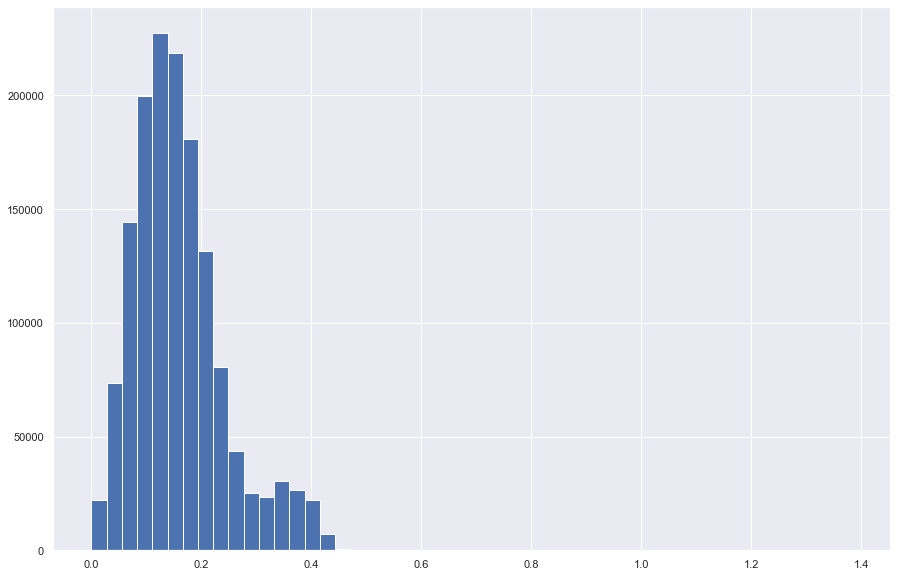

In [46]:
plot = train.log_v.hist(bins = 50)
plot.figure.set_size_inches(15, 10)

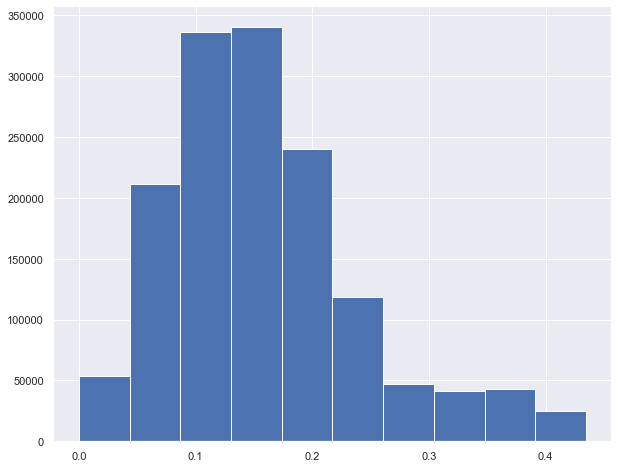

In [47]:
plot = train[train.log_v < train.log_v.quantile(0.999)].log_v.hist(bins = 10)
plot.figure.set_size_inches(10, 8)

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [48]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

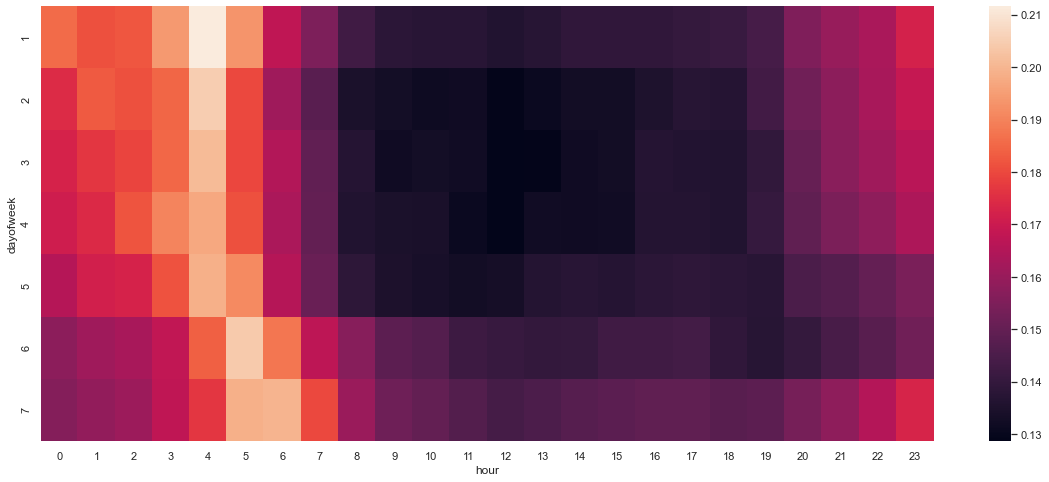

In [49]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

plot = sns.heatmap(pd.pivot_table(train, columns = "hour", index = "dayofweek", values = "log_v", aggfunc = np.median))

plot.figure.set_size_inches(20, 8)

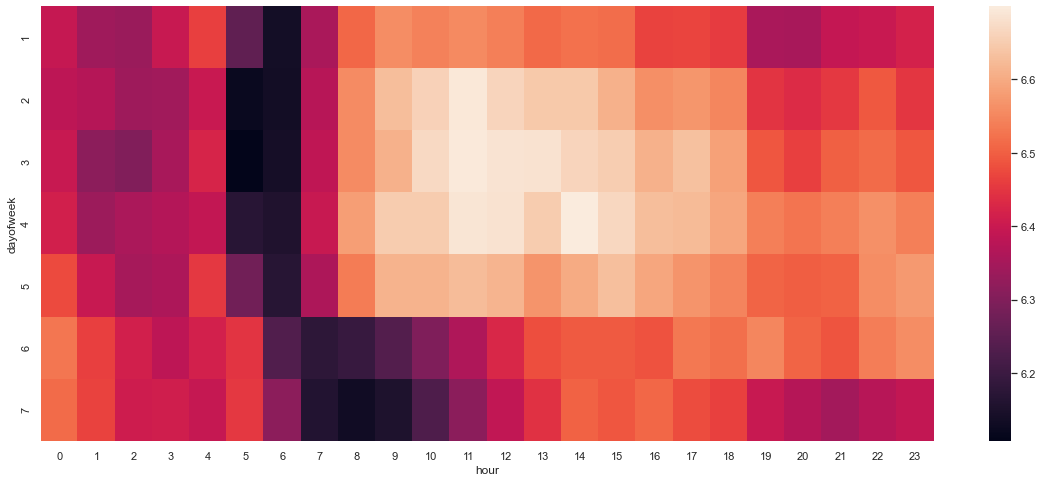

In [50]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

plot = sns.heatmap(pd.pivot_table(train, columns = "hour", index = "dayofweek", values = "log_trip_duration", aggfunc = np.median))

plot.figure.set_size_inches(20, 8)

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [51]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [52]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train["traffic_jam"] = 0
train.loc[(train.hour.isin([i for i in range(7, 20)])) & (train.dayofweek.isin([1, 2, 3, 4, 5])), "traffic_jam"] = 1

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [53]:
train["start_from_straing_point"] = 0
train.loc[train.pickup_longitude < -121, "start_from_straing_point"] = 1

train["finish_from_straing_point"] = 0
train.loc[train.pickup_longitude < -121, "finish_from_straing_point"] = 1

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

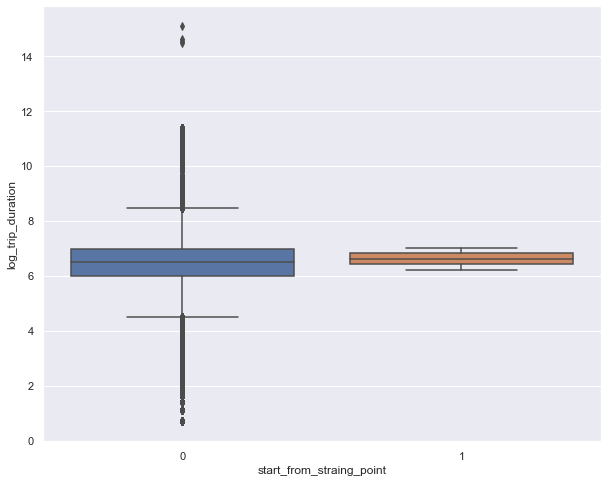

In [54]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

plot = sns.boxplot(data = train, y = "log_trip_duration", x = "start_from_straing_point")

plot.figure.set_size_inches(10, 8)

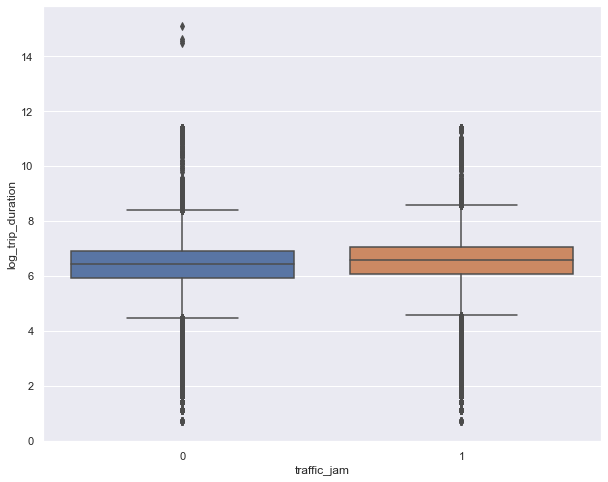

In [55]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

plot = sns.boxplot(data = train, y = "log_trip_duration", x = "traffic_jam")

plot.figure.set_size_inches(10, 8)

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [56]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.spatial.distance import cdist


COL_NAMES = dict(
    pick_lat="pickup_latitude",
    pick_lon="pickup_longitude",
    drop_lat="dropoff_latitude",
    drop_lon="dropoff_longitude"
)
class MapGridTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, loc, col, row, col_names=COL_NAMES):
        self.location_mh = loc
        self.col = col
        self.row = row
        self.col_names = col_names
        self.pick_lat = col_names["pick_lat"]
        self.pick_lon = col_names["pick_lon"]
        self.drop_lat = col_names["drop_lat"]
        self.drop_lon = col_names["drop_lon"]
        self.lat_min, self.lat_max = loc[:, 1].min(), loc[:, 1].max()
        self.lon_min, self.lon_max = loc[:, 0].min(), loc[:, 0].max()
        
        
#     def create_box_(self, loc):
#         polygon_loc = [
#                     [(loc[0] - self.walls[0] / 2), loc[1] - self.walls[1] / 2],
#                     [loc[0] + self.walls[0] / 2, loc[1] - self.walls[1] / 2],
#                     [loc[0] + self.walls[0] / 2, loc[1] + self.walls[1] / 2],
#                     [loc[0] - self.walls[0] / 2, loc[1] + self.walls[1] / 2]
#                   ]
#         return polygon_loc

#     def show_map(self):
#         self.walls, self.circles_loc = self._fit()
#         _map = Map(center=((self.location_mh[:, 0]).mean(), (self.location_mh[:, 1]).mean()),
#                    zoom=11, basemap=basemaps.Esri.NatGeoWorldMap)

#         circles = [(CircleMarker(location=(lat, long), fill_color='red',
#                                  fill_opacity=1, radius=5, stroke=False)) for lat, long in self.circles_loc]
#         polygons = [(Polygon(locations=self.create_box_(loc), fill_opacity=0)) for loc in self.circles_loc]

#         circles_layer = LayerGroup(layers=circles)
#         polygon_layer = LayerGroup(layers=polygons)

#         _map.add_layer(circles_layer)
#         _map.add_layer(polygon_layer)

#         return _map

    def fit(self):
        self.walls = [(self.location_mh[:, 0].max() - self.location_mh[:, 0].min()) / self.col, \
              (self.location_mh[:, 1].max() - self.location_mh[:, 1].min()) / self.row]

        self.circles_loc = np.array([(((self.location_mh[:, 0].min() + i * (self.walls[0] / 2))), \
                               (self.location_mh[:, 1].min() + j * (self.walls[1] / 2)) ) \
                            for i in range(1, (self.col) * 2, 2) for j in range(1, (self.row) * 2, 2)])

        return self.walls, self.circles_loc        


    def get_sector_idx(self, X):
        
        self.walls, self.circles_loc = self.fit()
        
        
        pickup_idx = cdist(X.loc[:, [self.pick_lon, self.pick_lat]],
                           self.circles_loc).argmin(axis=1)
        dropoff_idx = cdist(X.loc[:, [self.drop_lon, self.drop_lat]],
                            self.circles_loc).argmin(axis=1)
        qry = f"@self.lat_min <= {self.pick_lat} <= @self.lat_max \
               and @self.lon_min <= {self.pick_lon} <= @self.lon_max"
        pickup_valid = X.eval(qry).to_numpy()
        pickup_idx[~pickup_valid] = -1
        qry = f"@self.lat_min <= {self.drop_lat} <= @self.lat_max \
               and @self.lon_min <= {self.drop_lon} <= @self.lon_max"
        dropoff_valid = X.eval(qry).to_numpy()
        dropoff_idx[~dropoff_valid] = -1
        return pickup_idx, dropoff_idx

    def transform(self, X):
        return (X,) + self.get_sector_idx(X)

In [57]:
mh = np.array(train.sample(1000)[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']])

In [58]:
a = MapGridTransformer(mh, 4,5)

In [59]:
b = a.transform(train)

In [60]:
train["start_quadrant"] = b[1]

In [61]:
train["finish_quadrant"] = b[2]

In [62]:
X.sample()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,dayofweek,hour,month,dayofyear,abnormal_day
1109252,id1672677,1,2016-04-06 20:38:26,1,-74.001106,40.731796,-73.996452,40.760689,N,3,20,4,97,0


**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [63]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
y = train["log_trip_duration"]
X = train.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

numeric_features = ["dayofweek", "month", "hour", "dayofyear", "log_s"]
categorical = ["abnormal_day", "traffic_jam", "start_from_straing_point", "finish_from_straing_point", "start_quadrant", "finish_quadrant"]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.5567


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [64]:
train.vendor_id.unique()

array([2, 1], dtype=int64)

In [65]:
train.passenger_count.unique()

array([1, 6, 4, 2, 3, 5, 0, 7, 9, 8], dtype=int64)

In [66]:
train.store_and_fwd_flag.unique()

array(['N', 'Y'], dtype=object)

In [67]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

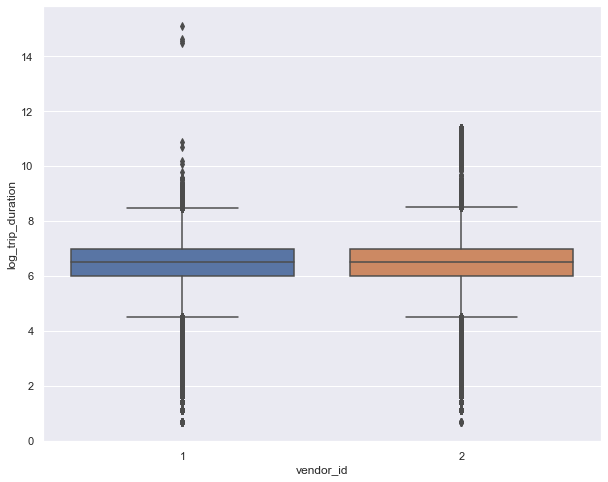

In [68]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

plot = sns.boxplot(data = train, y = "log_trip_duration", x = "vendor_id")

plot.figure.set_size_inches(10, 8)

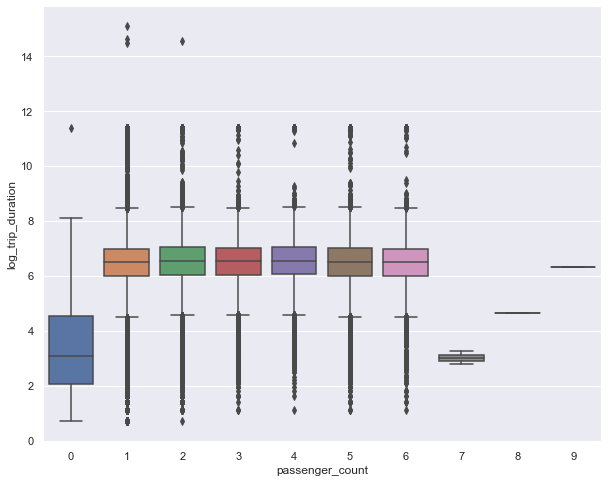

In [69]:

plot = sns.boxplot(data = train, y = "log_trip_duration", x = "passenger_count")

plot.figure.set_size_inches(10, 8)

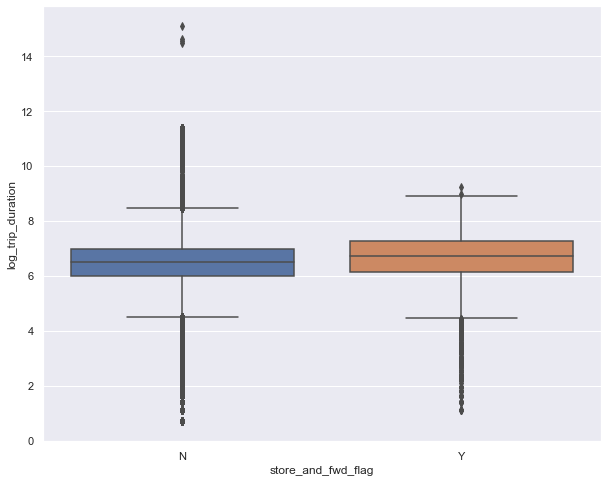

In [70]:

plot = sns.boxplot(data = train, y = "log_trip_duration", x = "store_and_fwd_flag")

plot.figure.set_size_inches(10, 8)

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [71]:
train.vendor_id = np.where(train.vendor_id == 1, 0, 1)

In [72]:
train.store_and_fwd_flag = np.where(train.store_and_fwd_flag == "N", 0, 1)

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [73]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
y = train["log_trip_duration"]
X = train.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

numeric_features = ["dayofweek", "month", "hour", "dayofyear", "log_s"]
categorical = ["abnormal_day", "traffic_jam", 
               "start_from_straing_point", "finish_from_straing_point", 
               "start_quadrant", "finish_quadrant"]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.5567


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

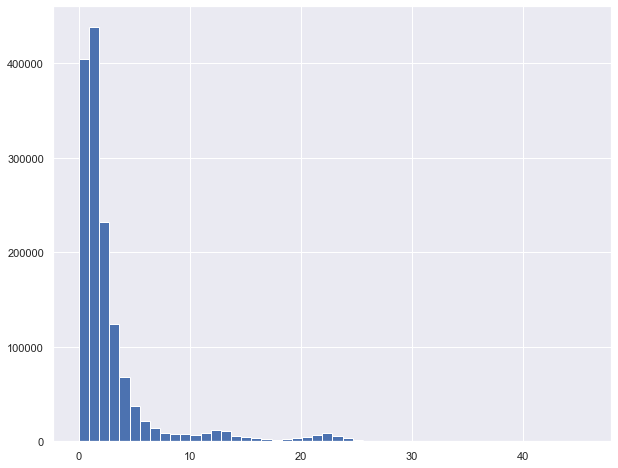

In [74]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plot = train[train.s < train.s.quantile(0.9999)].s.hist(bins = 50)
plot.figure.set_size_inches(10, 8)

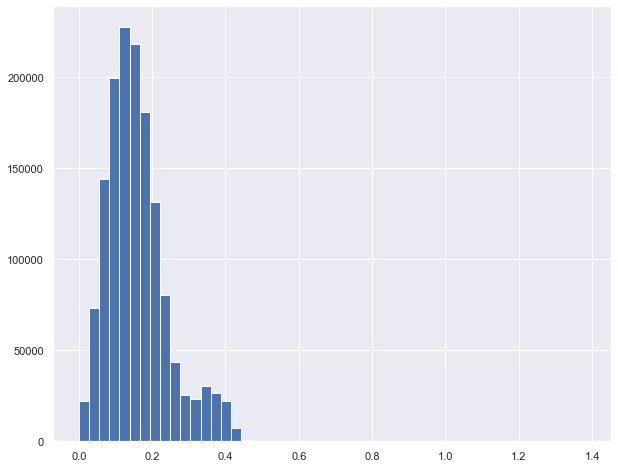

In [75]:
plot = train.log_v.hist(bins = 50)
plot.figure.set_size_inches(10, 8)

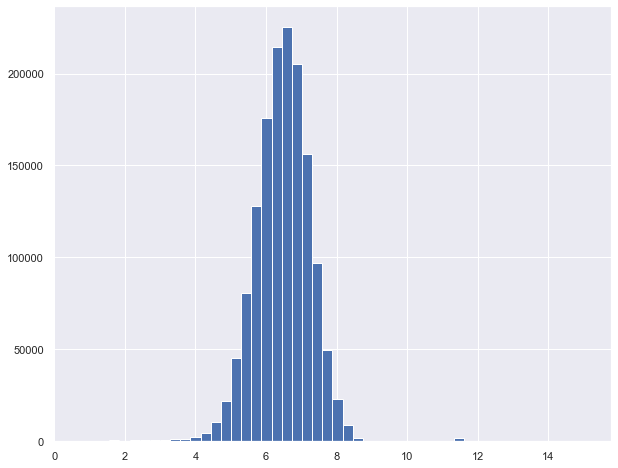

In [76]:
plot = train.log_trip_duration.hist(bins = 50)
plot.figure.set_size_inches(10, 8)

In [77]:
train["residues"] = np.abs(model.predict(X) - train["log_trip_duration"])

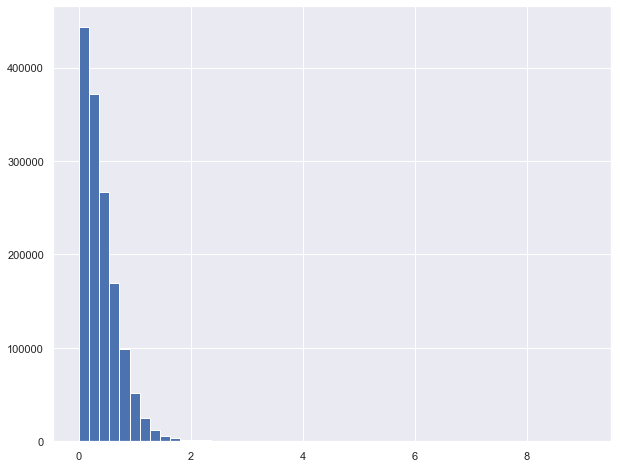

In [78]:
plot = train.residues.hist(bins = 50)
plot.figure.set_size_inches(10, 8)

In [79]:
filtered_train = train[(train.residues < train.residues.quantile(0.999)) | 
                       (train.log_v < train.log_v.quantile(0.999)) | 
                       (train.s < train.s.quantile(0.999))]

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [80]:
filtered_train.loc[filtered_train.start_quadrant.isin([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 5, 10, 4]), "start_quadrant"] = -2

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [81]:
filtered_train.loc[filtered_train.finish_quadrant.isin([14, 15, 16, 17, 18, 19, 20, 10, 13, 4]), "finish_quadrant"] = -2

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [82]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
y = filtered_train["log_trip_duration"]
X = filtered_train.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

numeric_features = ["dayofweek", "month", "hour", "dayofyear", "log_s"]
categorical = ["abnormal_day", "traffic_jam", 
               "start_from_straing_point", "finish_from_straing_point", 
               "start_quadrant", "finish_quadrant"]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer)])

model = pipeline.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [83]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
y = filtered_train["log_trip_duration"]
X = filtered_train.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

numeric_features = ["dayofweek", "month", "hour", "dayofyear", "log_s"]
categorical = ["abnormal_day", "traffic_jam", 
               "start_from_straing_point", "finish_from_straing_point", 
               "start_quadrant", "finish_quadrant"]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.5568


In [84]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.linear_model import Lasso

y = filtered_train["log_trip_duration"]
X = filtered_train.drop(columns=["log_trip_duration"])

numeric_features = ["dayofweek", "month", "hour", "dayofyear", "log_s"]
categorical = ["abnormal_day", "traffic_jam", 
               "start_from_straing_point", "finish_from_straing_point", 
               "start_quadrant", "finish_quadrant"]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer)
])

model = pipeline.fit(X)
X_trans = model.transform(X)

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [87]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import GridSearchCV

X = X_trans

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

alphas = np.logspace(-4, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

Best alpha = 0.2069


Text(0, 0.5, 'CV score')

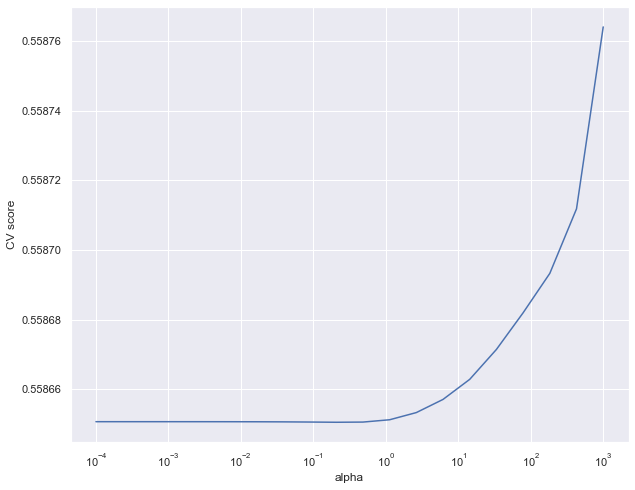

In [89]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")


In [90]:
X = X_trans

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

alphas = np.logspace(-4, 3, 20)
searcher = GridSearchCV(Lasso(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

Best alpha = 0.0001


Text(0, 0.5, 'CV score')

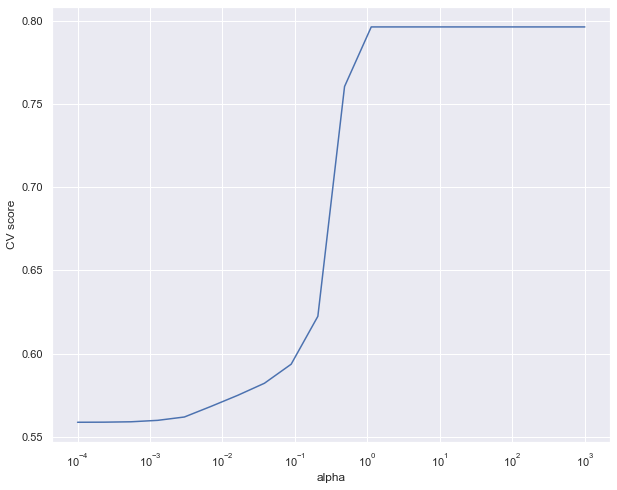

In [91]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [115]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

metadata = {}

for i in np.logspace(-4, 3, 20):

    model = Lasso(alpha=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metadata[i] = {"mean_squared_error" :  mean_squared_error(y_test, y_pred, squared=False), 
                        "non_zero_weight_count" : sum(model.coef_ != 0)}


In [117]:
min([i['mean_squared_error'] for i in metadata.values()])

0.5564310072108073

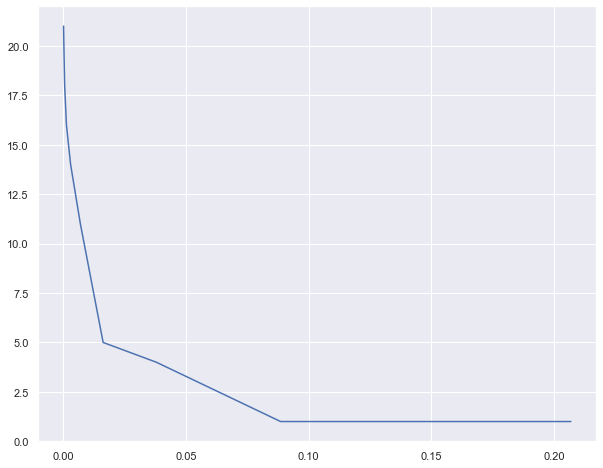

In [95]:
plt.plot(list(metadata.keys())[:10], [i['non_zero_weight_count'] for i in metadata.values()][:10])

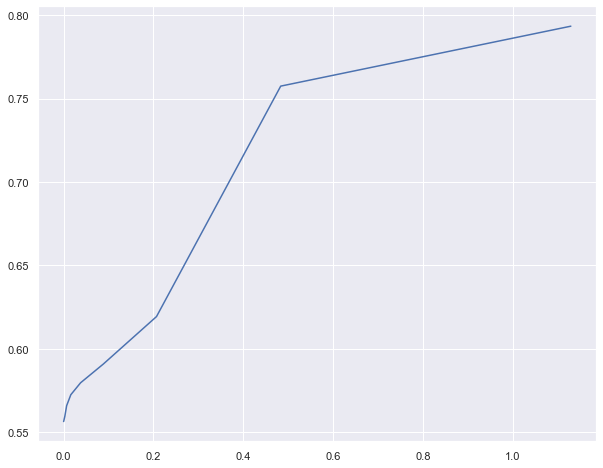

In [96]:
plt.plot(list(metadata.keys())[:12], [i['mean_squared_error'] for i in metadata.values()][:12])

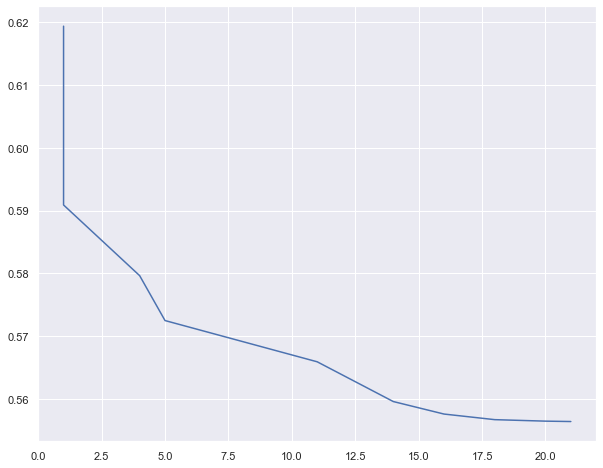

In [97]:
plt.plot([i['non_zero_weight_count'] for i in metadata.values()][:10], [i['mean_squared_error'] for i in metadata.values()][:10])

In [98]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

metadata = {}

for i in np.logspace(-4, 3, 20):

    model = Ridge(alpha=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metadata[i] = {"mean_squared_error" :  mean_squared_error(y_test, y_pred, squared=False), 
                        "non_zero_weight_count" : sum(model.coef_ != 0)}


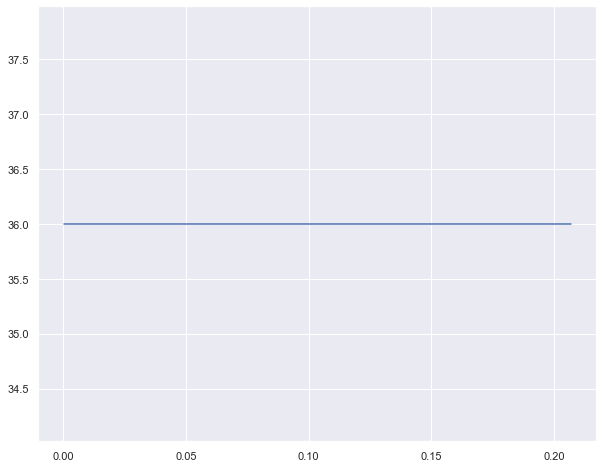

In [105]:
plt.plot(list(metadata.keys())[:10], [i['non_zero_weight_count'] for i in metadata.values()][:10])

In [108]:
[i['mean_squared_error'] for i in metadata.values()]

[0.5562876676135072,
 0.5562876670995551,
 0.5562876658995809,
 0.5562876630993627,
 0.556287656572934,
 0.5562876414057424,
 0.5562876063954474,
 0.5562875268587464,
 0.5562873528929659,
 0.5562870062564869,
 0.5562864706743403,
 0.5562862444251836,
 0.5562882600902918,
 0.5562956352839833,
 0.556310144862352,
 0.55633096111148,
 0.556354322121869,
 0.5563764042962348,
 0.5564013073148886,
 0.5564528680336587]

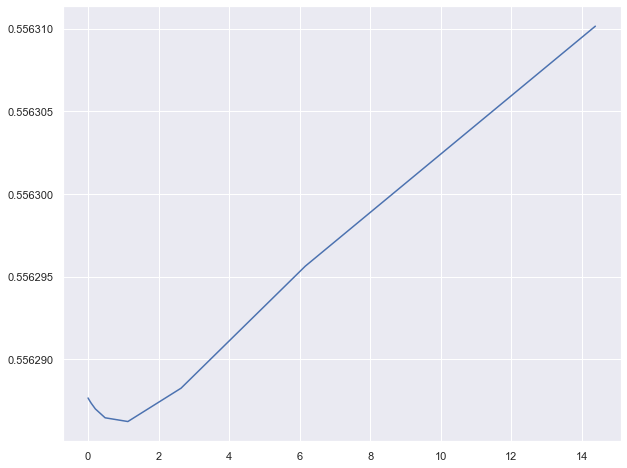

In [114]:
plt.plot(list(metadata.keys())[:15], [i['mean_squared_error'] for i in metadata.values()][:15])

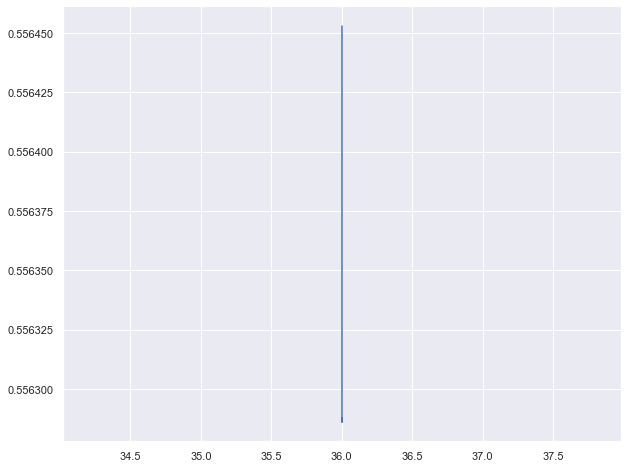

In [107]:
plt.plot([i['non_zero_weight_count'] for i in metadata.values()], [i['mean_squared_error'] for i in metadata.values()])

In [110]:
min([i['mean_squared_error'] for i in metadata.values()])

0.5562862444251836

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [123]:
filtered_train["start_finish"] = filtered_train["start_quadrant"].astype(str) + "_" + filtered_train["finish_quadrant"].astype(str) 

<ipython-input-123-6c11acf86af9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train["start_finish"] = filtered_train["start_quadrant"].astype(str) + "_" + filtered_train["finish_quadrant"].astype(str)


In [130]:
y = filtered_train["log_trip_duration"]
X = filtered_train.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

numeric_features = ["dayofweek", "month", "hour", "dayofyear", "log_s"]
categorical = ["abnormal_day", "traffic_jam", 
               "start_from_straing_point", "finish_from_straing_point", 
               "start_quadrant", "finish_quadrant", "start_finish"]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(alpha=0.2069))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.5491


In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.